In [ ]:
!pip install torch torchvision scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Loading the Diabetes Data here
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target
print("Initial data shape:", X_diabetes.shape, y_diabetes.shape)

threshold = y_diabetes.mean()
y_diabetes_binary = (y_diabetes > threshold).astype(int)
print("Threshold for classification:", threshold)
print("Binary target values (first 10):", y_diabetes_binary[:10])

X_train_d, X_test_d, y_train_d, y_test_d, y_train_d_binary, y_test_d_binary = train_test_split(
    X_diabetes, y_diabetes, y_diabetes_binary, test_size=0.2, random_state=42
)
print("Train/Test split shapes:", X_train_d.shape, X_test_d.shape)


scaler_d = StandardScaler()
X_train_d = scaler_d.fit_transform(X_train_d)
X_test_d = scaler_d.transform(X_test_d)

X_train_d_tensor = torch.tensor(X_train_d, dtype=torch.float32).to(device)
X_test_d_tensor = torch.tensor(X_test_d, dtype=torch.float32).to(device)
y_train_d_tensor = torch.tensor(y_train_d, dtype=torch.float32).view(-1, 1).to(device)
y_test_d_tensor = torch.tensor(y_test_d, dtype=torch.float32).view(-1, 1).to(device)
y_train_d_binary_tensor = torch.tensor(y_train_d_binary, dtype=torch.float32).view(-1, 1).to(device)
y_test_d_binary_tensor = torch.tensor(y_test_d_binary, dtype=torch.float32).view(-1, 1).to(device)

Initial data shape: (442, 10) (442,)
Threshold for classification: 152.13348416289594
Binary target values (first 10): [0 0 0 1 0 0 0 0 0 1]
Train/Test split shapes: (353, 10) (89, 10)


In [5]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, classification=False):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        if classification:
            x = self.sigmoid(x)
        return x

model_regression = FeedforwardNN(X_train_d.shape[1], 1).to(device)
model_classification = FeedforwardNN(X_train_d.shape[1], 1).to(device)
print("Models initialized.")


Models initialized.


In [6]:
criterion_regression = nn.MSELoss()
criterion_classification = nn.BCELoss()
optimizer_regression = optim.Adam(model_regression.parameters(), lr=0.01)
optimizer_classification = optim.Adam(model_classification.parameters(), lr=0.01)
print("Loss functions and optimizers defined.")

Loss functions and optimizers defined.


In [7]:
def train_model(model, optimizer, X_train, y_train, criterion, epochs=100, classification=False):
    for epoch in range(epochs):
        model.train()
        predictions = model(X_train, classification=classification)
        loss = criterion(predictions, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

print("Training Regression Model")
train_model(model_regression, optimizer_regression, X_train_d_tensor, y_train_d_tensor, criterion_regression)

print("Training Classification Model")
train_model(model_classification, optimizer_classification, X_train_d_tensor, y_train_d_binary_tensor, criterion_classification, classification=True)



Training Regression Model
Epoch 10/100, Loss: 27607.7227
Epoch 20/100, Loss: 18774.8750
Epoch 30/100, Loss: 6589.8745
Epoch 40/100, Loss: 5497.5039
Epoch 50/100, Loss: 4105.1685
Epoch 60/100, Loss: 3446.9956
Epoch 70/100, Loss: 3153.6394
Epoch 80/100, Loss: 2996.1196
Epoch 90/100, Loss: 2888.9404
Epoch 100/100, Loss: 2817.2996
Training Classification Model
Epoch 10/100, Loss: 0.4833
Epoch 20/100, Loss: 0.4382
Epoch 30/100, Loss: 0.4038
Epoch 40/100, Loss: 0.3558
Epoch 50/100, Loss: 0.2959
Epoch 60/100, Loss: 0.2233
Epoch 70/100, Loss: 0.1454
Epoch 80/100, Loss: 0.0823
Epoch 90/100, Loss: 0.0424
Epoch 100/100, Loss: 0.0214


In [8]:

from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model_regression(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        mse = mean_squared_error(y_test.cpu().numpy(), predictions)
        r2 = r2_score(y_test.cpu().numpy(), predictions)
        print("Regression predictions (first 5):", predictions[:5].flatten())
    return mse, r2

# Evaluate the Regression model
mse_d, r2_d = evaluate_model_regression(model_regression, X_test_d_tensor, y_test_d_tensor)
print(f"Regression Model - MSE: {mse_d:.4f}, R-squared: {r2_d:.4f}")


Regression predictions (first 5): [157.44014 186.80965 141.60532 320.6678   90.65883]
Regression Model - MSE: 2995.7659, R-squared: 0.4346


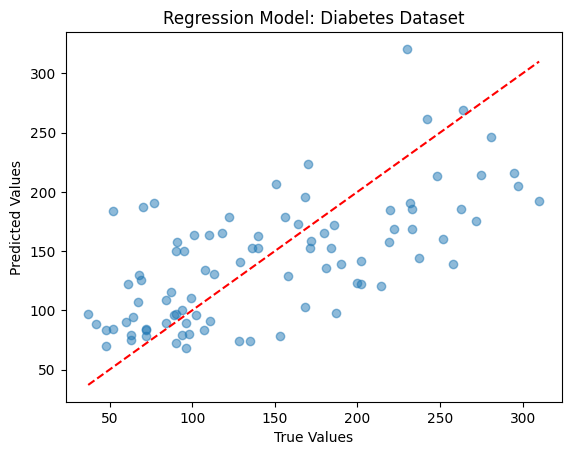

In [9]:
import matplotlib.pyplot as plt

def plot_results_regression(y_test, predictions, title):
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()

# Visualize results for the Regression model
with torch.no_grad():
    predictions_d = model_regression(X_test_d_tensor).cpu().numpy()
    plot_results_regression(y_test_d_tensor.cpu().numpy(), predictions_d, "Regression Model: Diabetes Dataset")


In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model_classification(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test, classification=True).cpu().numpy() > 0.5
        accuracy = accuracy_score(y_test.cpu().numpy(), predictions)
        cm = confusion_matrix(y_test.cpu().numpy(), predictions)
        print("Classification predictions (first 5):", predictions[:5].flatten())
    return accuracy, cm

# Evaluate the Classification model
accuracy_d, cm_d = evaluate_model_classification(model_classification, X_test_d_tensor, y_test_d_binary_tensor)
print(f"Classification Model - Accuracy: {accuracy_d:.4f}")


Classification predictions (first 5): [False False  True  True False]
Classification Model - Accuracy: 0.7865


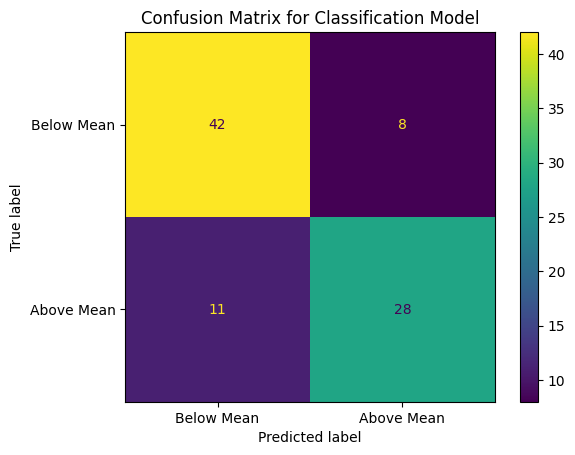

In [11]:
ConfusionMatrixDisplay(confusion_matrix=cm_d, display_labels=["Below Mean", "Above Mean"]).plot()
plt.title("Confusion Matrix for Classification Model")
plt.show()
